In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from funcs import gaussian_noise, plot_settings
plot_settings()
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
# заводим функции
# 1-v

mu = 8*1e5
f_0 = 300

x_ = lambda t: np.cos(2*np.pi*f_0*t + mu*t**2)

beta = 3*1e3

k_ = lambda t: np.exp(-beta*t)

size = 1000

a, b = 0, 0.01

t = np.linspace(a, b, size)

k = k_(t)
x_exact = x_(t)


### 1 решение прямой задачи

In [3]:
f = np.convolve(k, x_exact)

Text(0, 0.5, 'x')

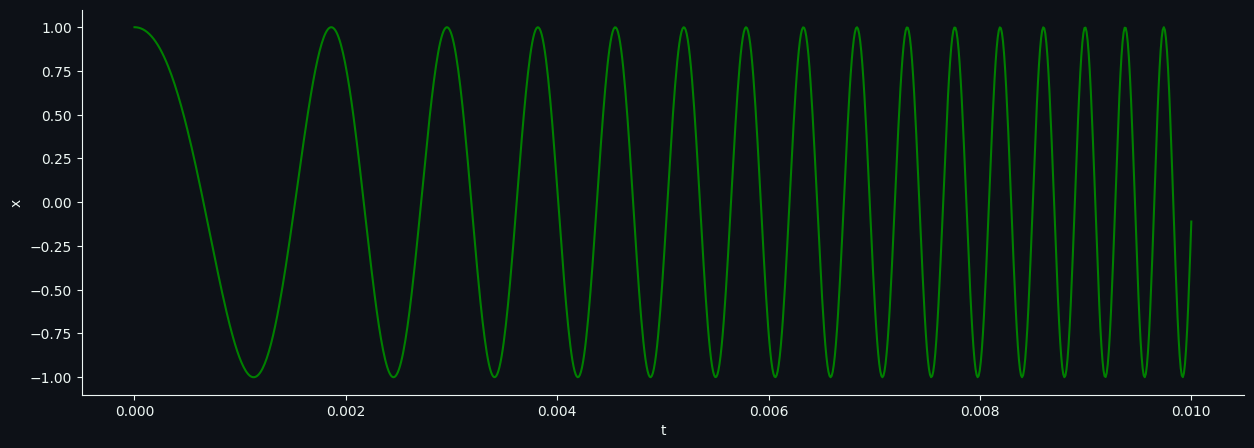

In [4]:
plt.plot(t, x_exact)
plt.xlabel("t")
plt.ylabel("x")

In [5]:
t_conv = np.linspace(a, (t[1]-t[0])*len(f), len(f))

Text(0.5, 1.0, 'convolve result')

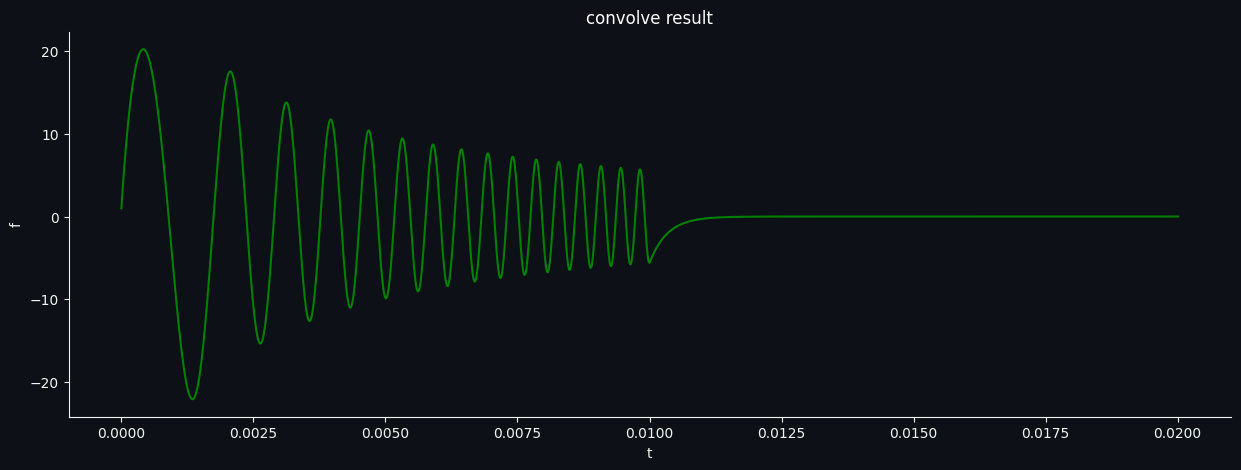

In [6]:
plt.plot(t_conv, f)
plt.xlabel("t")
plt.ylabel("f")
plt.title("convolve result", color='w')

### 2 добавить шум

In [7]:
f_noise = f + gaussian_noise(f.shape)

In [8]:
from scipy.fft import fftfreq, fft, ifft

## 3 решение с регуляризацией Тихонова 

In [9]:
def tikhanov_regularization(f: np.ndarray, k: np.ndarray, t: np.ndarray,
                            alpha: float = 0.1, m = lambda o: np.abs(o)) -> np.ndarray:
    
    F = fft(f)
    K = fft(k, len(f))
    #print(f.shape[0], t[1] - t[0])
    omega = fftfreq(f.shape[0], d = t[1] - t[0])

    x_alpha_o = np.empty_like(f)
    # print(K.conjugate(), K)
    x_alpha_o = F * np.conjugate(K) / (np.conjugate(K) * K + alpha * m(omega))

    x_alpha = ifft(x_alpha_o)
    
    return np.real(x_alpha) 



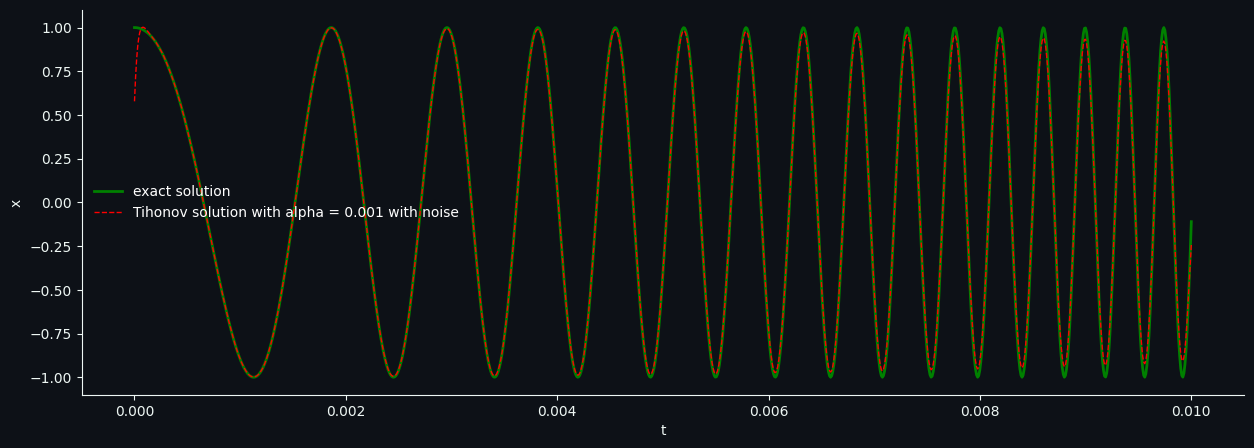

In [10]:
alp = 1e-3
x_sol = tikhanov_regularization(f, k, t, alp)
x_noise_sol = tikhanov_regularization(f_noise, k, t, alp)


#plt.plot(x_sol, label=f'Tihonov solution with alpha = {alp}')
plt.plot(t, x_exact, linewidth = 2, label='exact solution')
plt.plot(t, x_noise_sol[:t.shape[0]],'--', linewidth = 1, label=f'Tihonov solution with alpha = {alp} with noise')
plt.xlabel("t")
plt.ylabel("x")
plt.legend(labelcolor='w') 

### 4 поиск по сигма

In [11]:
from funcs import relative_error
from scipy import optimize

In [70]:
def optimal_alpha(sigma, mu=0., alpha_0 = 1e-3) -> float:
    func = lambda alpha: relative_error(x_exact, tikhanov_regularization(f + gaussian_noise(f.shape, mu=mu, sigma=sigma), k, t, alpha)[:t.size])
    res = optimize.minimize(func, alpha_0, method="Powell")
    return res.x[0]

In [74]:
sigma_1, sigma_2 = 1, 1e-3
n = 1000
alphas_1 = [optimal_alpha(sigma_1) for _ in range(n)]
alphas_2 = [optimal_alpha(sigma_2) for _ in range(n)]

Text(0.5, 1.0, 'log(alpha) histogram for sigma=1')

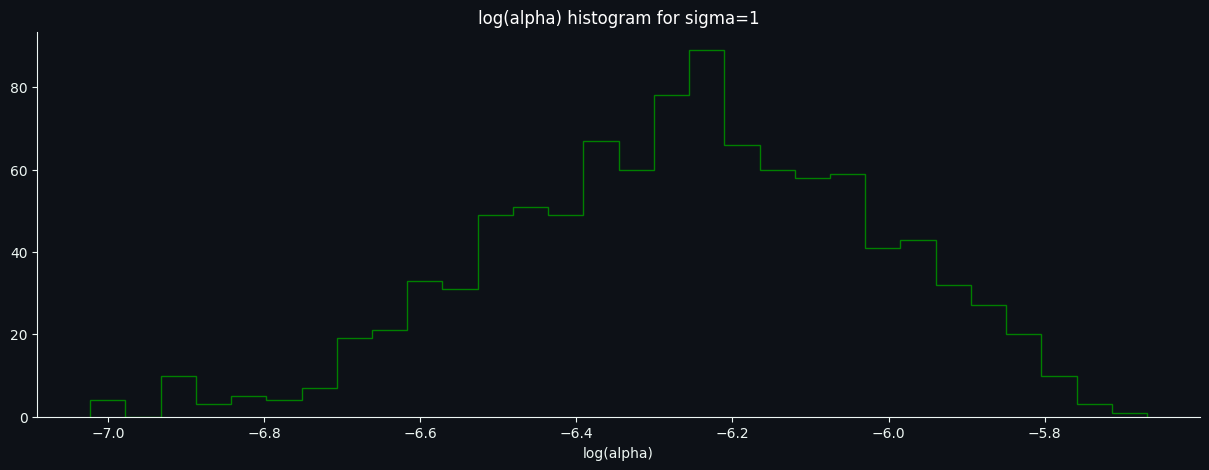

In [75]:
n_bins = int(np.sqrt(n))

alpha_log_1 = np.log(alphas_1)

plt.hist(alpha_log_1, bins=np.linspace(min(alpha_log_1), max(alpha_log_1), n_bins), histtype="step")
plt.xlabel("log(alpha)")
plt.title(f"log(alpha) histogram for sigma={sigma_1}", color='w')

C:\Users\droid\AppData\Local\Temp\ipykernel_16880\4220560903.py:1: RuntimeWarning: invalid value encountered in log
  alpha_log_2 = np.log(alphas_2)


Text(0.5, 1.0, 'log(alpha) histogram for sigma=0.001')

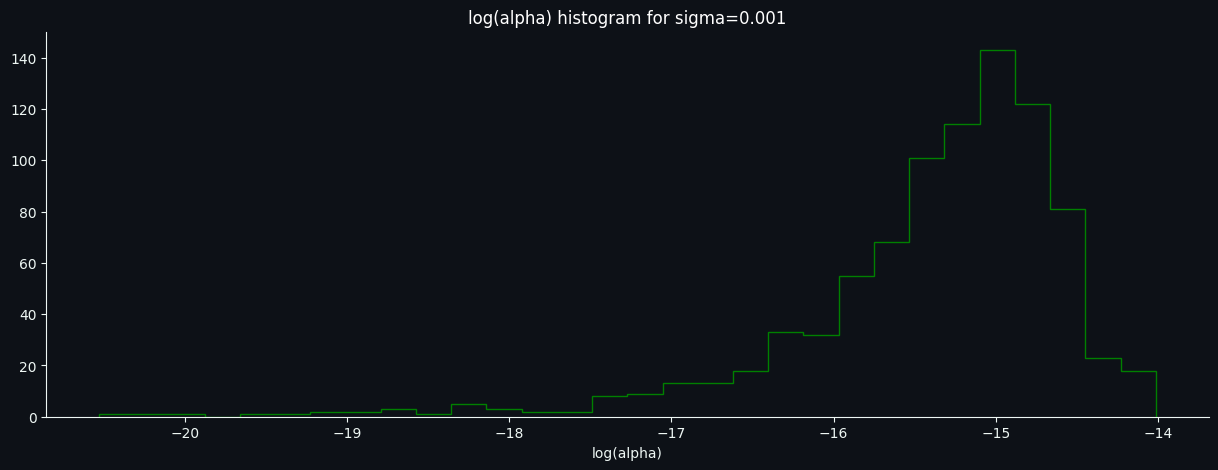

In [76]:
alpha_log_2 = np.log(alphas_2)

plt.hist(alpha_log_2, bins=np.linspace(min(alpha_log_2), max(alpha_log_2), n_bins), histtype="step")
plt.xlabel("log(alpha)")
plt.title(f"log(alpha) histogram for sigma={sigma_2}", color='w')